In [30]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from growth.sweep.sweep import Sweep
from clones.validation.sweep import SweepBenchmark
from clones.visualization.settings import *
%matplotlib inline

In [2]:
figsize = (2, 2)
savedir = './graphics/synthetic/'
savefig = lambda fig, name: fig.savefig(join(savedir, '{:s}.pdf'.format(name)), dpi=400, rasterized=True, transparent=True)

In [2]:
ls ../../../data/synthetic/

aggregate.py    build_sweep.py  complete/       landing/


# Synthetic data generation

In [4]:
"""
growth_conditions: 8x8 with 4 recomb gen
Sweep_181201_191516: 1x16 with 4 gen
Sweep_181201_191521: 1x16 with 2 gen
"""

path = '../../../data/synthetic/complete/growth_conditions'
sweep = Sweep.load(path)

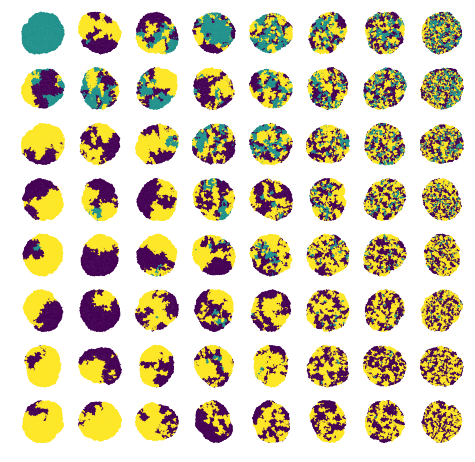

In [9]:
fig = sweep.plot_culture_grid(replicate_id=0, s=2)

In [5]:
""" Generate microscopy. """

ambiguity, rho, bleedthrough = 0., 0., 0.

measurement_kwargs = dict(
    expression_capacity_sigma=1.,
    nuclear_stain_level=2.,
    control_level=0.5,
    nuclear_stain_sigma=0.01,
    control_sigma=0.01,
    measurement_noise=0.
)

kwargs = dict(
    measurement_kwargs=measurement_kwargs,
    microscopy_kwargs={'bg_level':0.2, 'radius': 6})

row = 1
images = {}
for i in range(8):    
    simulation = sweep[i+row*8]
    image = simulation.generate_microscopy(ambiguity, rho, bleedthrough, **kwargs)[1]
    images[i] = image

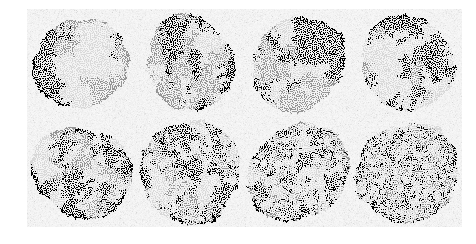

In [6]:
nrows = 2
ncols = 4
size = 2

fig = plt.figure(figsize=(ncols*size-0.2, nrows*size))
gs = GridSpec(nrows, ncols, wspace=0., hspace=0.)
axes = [fig.add_subplot(gs[i]) for i in range(nrows*ncols)]
for i, ax in enumerate(axes):
    ax.axis('off')
    _ = images[i].render(ax=ax)

savefig(fig, 'recombination_timing')

# Simulated trends

In [161]:
#data = sweep._results[sweep._results.percent_heterozygous!=1]
data = sweep._results
gb = data.groupby('column_id')

In [162]:
means = gb.mean()
stds = gb.std()

def plot_trend(yvar, yvar_label):
    fig, ax = plt.subplots(figsize=(2, 1.25))
    x = 2**means.recombination_start
    y = means[yvar]
    ystd = stds[yvar]
    y_SEM = ystd / np.sqrt(sweep.num_replicates)
    ax.scatter(x, y, s=1, c='k')
    ax.errorbar(x, y, yerr=y_SEM)
    ax.set_xscale('log', basex=2)
    ax.set_xticks([1,2,4,8,16,32,64,128])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Recombination start (no. cells)')
    ax.set_ylabel(yvar_label)
    return fig

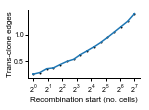

In [156]:
fig = plot_trend('transclone_edges', 'Trans-clone edges')
savefig(fig, 'transclone_edges')

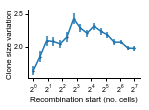

In [157]:
fig = plot_trend('clone_size_variation', 'Clone size variation')
savefig(fig, 'clone_size_variation')

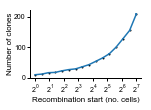

In [158]:
fig = plot_trend('num_clones', 'Number of clones')
savefig(fig, 'num_clones')

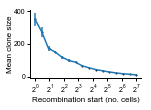

In [159]:
fig = plot_trend('mean_clone_size', 'Mean clone size')
savefig(fig, 'mean_clone_size')

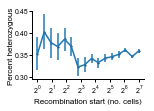

In [163]:
fig = plot_trend('percent_heterozygous', 'Percent heterozygous')
savefig(fig, 'percent_heterozygous')

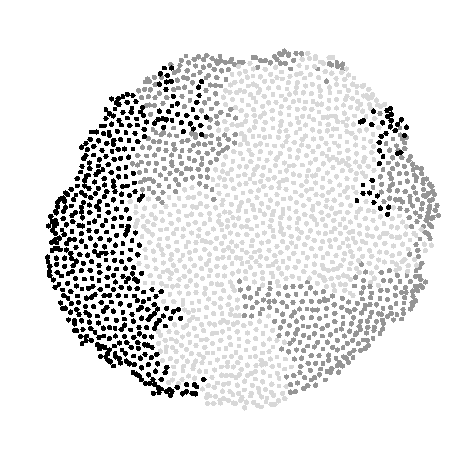

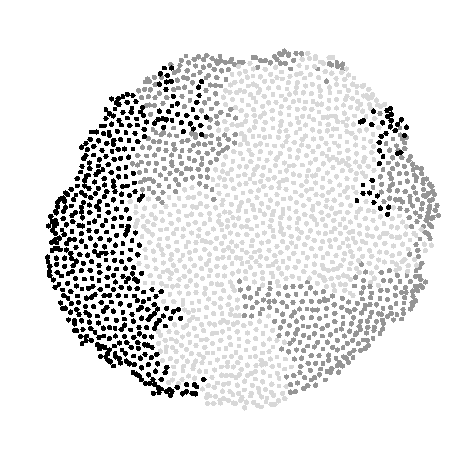

In [87]:
fig = image.render(ax=ax)

# Load synthetic benchmarking results

In [2]:
sweep_path = '../../../data/synthetic/Sweep_181201_191516'
sweep = Sweep.load(sweep_path)
sweep

1 x 16 sweep, 4 recombination generations

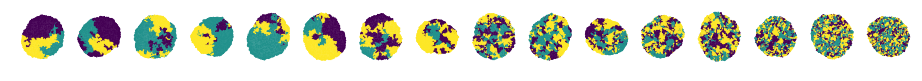

In [9]:
# plot single replicate for each batch
fig = sweep.plot_culture_grid(replicate_id=0, s=2)

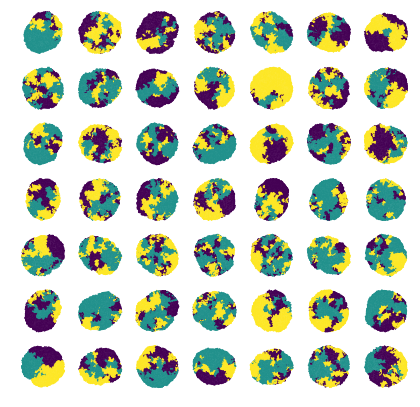

In [10]:
# plot all replicates for a single batch
fig = sweep.batches[0, 4].plot_culture_grid()

# load benchmarking results

In [162]:
benchmark = SweepBenchmark.load(sweep_path)

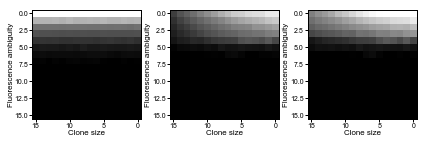

In [13]:
fig = benchmark.results.plot_absolute_error(log=True)

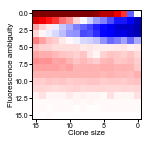

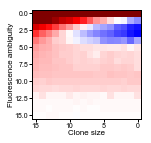

In [18]:
fig = benchmark.results.plot_relative_error(method='katz', reference_method='simple')
fig = benchmark.results.plot_relative_error(method='community', reference_method='simple')

# TESTING

In [2]:
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from clones.spatial.graphs import WeightedGraph
from sklearn.cluster import spectral_clustering
from growth.measure.fluorescence import Fluorescence

In [3]:
sweep_path = '../../../data/synthetic/Sweep_181201_191516'
sweep = Sweep.load(sweep_path)
simulation = sweep[5]

1 x 16 sweep, 4 recombination generations

In [426]:
measurements = simulation.measure(ambiguity=.4)

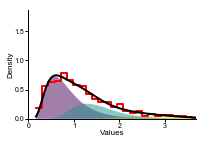

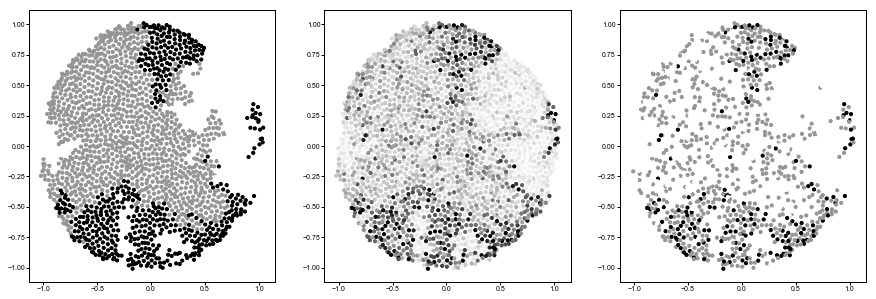

In [429]:
from clones.annotation.bayesian import BayesianClassifier

model = BayesianClassifier(measurements.fluorescence.values, crop=True)
model.plot_pdfs()

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
_ = ax0.scatter(*simulation.xy.T, c=measurements.ground, s=10, cmap=plt.cm.Greys)
_ = ax1.scatter(*simulation.xy.T, c=measurements.fluorescence.values, s=10, cmap=plt.cm.Greys, vmin=0, vmax=3)
_ = ax2.scatter(*simulation.xy.T, c=model.classifier(measurements.fluorescence.values), s=10, cmap=plt.cm.Greys)

In [417]:
clustering = AgglomerativeClassifier(measurements, n=25, num_labels=5, logratio=True)

In [418]:
centroids = {i:[] for i in range(clustering.num_labels)}
for i, x in enumerate(clustering.means):
    centroids[clustering.component_to_label[i]].append(x)

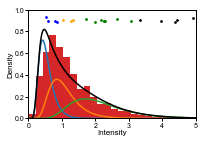

In [419]:
fig, ax = plt.subplots(figsize=(3, 2))
fluorescence.show_pdf(ax=ax)

ax.set_xlim(0, 5)
ax.set_ylim(0, 1)

colors = {0: 'blue', 1: 'orange', 2: 'green'}
for i in range(3, clustering.num_labels):
    colors[i] = 'k'

for i, centroid in centroids.items():
    ax.scatter(centroid, [.9+np.random.normal(scale=0.01) for _ in centroid], c=colors[i], s=3)

_ = ax.hist(measurements.fluorescence.values, bins=np.linspace(-1, 9, 50), density=True)

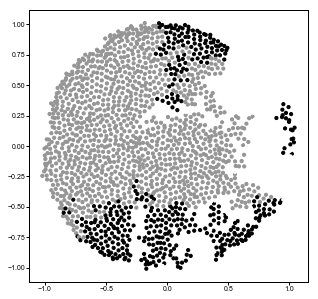

In [420]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(*simulation.xy.T, c=clustering.labels, s=10, cmap=plt.cm.Greys, vmin=0, vmax=2)